In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import gudhi as gd
from sklearn.neighbors import KernelDensity, KDTree
import random
import multiprocessing
from scipy.cluster import hierarchy

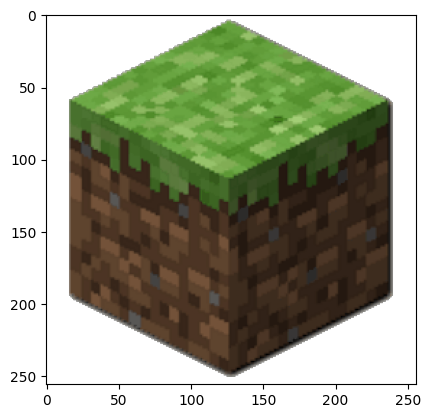

In [2]:
img_rgb = plt.imread('data/dirt.png', 'PNG')
plt.imshow(img_rgb)

In [3]:
img_rgb.shape

(256, 256, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


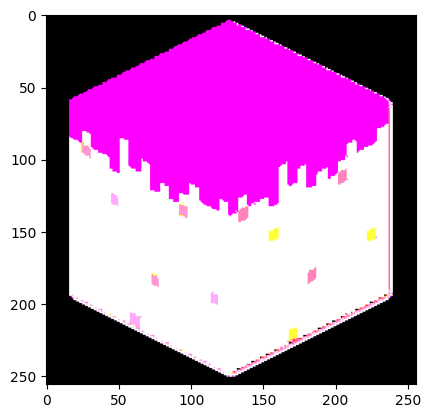

In [4]:
img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
plt.imshow(img_luv)

In [5]:
img_luv.shape

(256, 256, 3)

In [6]:
l, u, v = [], [], []
for i in range(img_luv.shape[0]):
    for j in range(img_luv.shape[1]):
        l.append(img_luv[i, j, 0])
        u.append(img_luv[i, j, 1])
        v.append(img_luv[i, j, 2])

In [7]:
x = np.vstack((l, u, v)).T
x.shape

(65536, 3)

In [8]:
print(x)

[[ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 ...
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]]


In [9]:
def parallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

In [10]:
kde = KernelDensity(bandwidth=2.0, atol=0.0005, rtol=0.01).fit(x) 
log_prob = parallel_score_samples(kde, x)

In [11]:
prob = np.exp(log_prob)

In [12]:
sparse = 3
sparse_matrix = np.asarray([[(j%sparse==0)&(i%sparse==0) for i in range(img_luv.shape[1])] for j in range(img_luv.shape[0])])
sparse_array = sparse_matrix.flatten()

In [13]:
x_train = x[sparse_array]
x_train = np.asarray([list(x_train[random.randrange(x_train.shape[0])]) for i in np.arange(20000)])
x_train.shape

(20000, 3)

In [14]:
linked = hierarchy.linkage(x_train, 'single')

In [ ]:
plt.figure(figsize=(14, 7))
hierarchy.dendrogram(linked, p=100, truncate_mode='level')
plt.show()

In [ ]:
kdt = KDTree(x, metric='euclidean')

In [ ]:
sigmas = np.linspace(0, 5, 10)
avg_neighbor_count = [np.mean([kdt.query_radius([x_train[i]], rads[j], return_distance=False)[0].shape[0] for i in range(x_train.shape[0])]) 
           for j in range(len(sigmas))]

In [ ]:
plt.plot(sigmas, avg_neighbor_count)

In [ ]:
sigma = 2